In [0]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [0]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


In [0]:
rgb_img = plt.imread("china.jpg")
gray_img = rgb2gray(rgb_img)


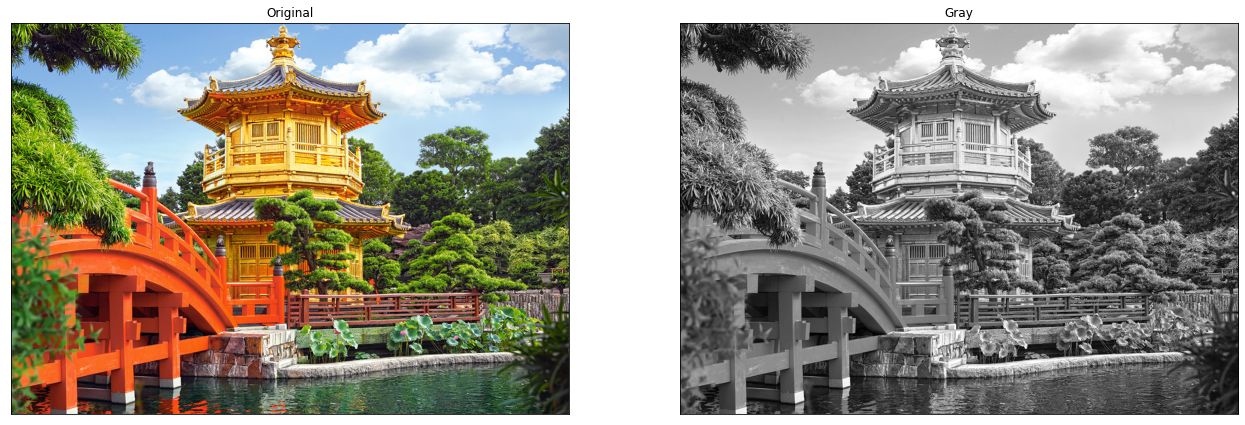

In [0]:
plt.figure(figsize=(22,12))
plt.subplot(121)
plt.imshow(rgb_img)
plt.title("Original")
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(gray_img, cmap='gray')
plt.title("Gray")
plt.xticks([])
plt.yticks([])
plt.show()

In [0]:
s = 3
num_octave = 4 
s0 = 1.3
sigma = 1.6
r_th = 10
t_c = 0.03
w = 16
R_th = (r_th+1)**2 / r_th

In [0]:
def gaussian_filter(sigma):
  size = 2 * np.ceil(3 * sigma) + 1
  # print(size, size//2, size // 2 + 1)
  x, y = np.mgrid[-size//2 + 1:size//2 + 1, -size//2 + 1:size//2 + 1]
  g = np.exp(-((x**2 + y**2)/(2.0*sigma**2))) / (2*np.pi*sigma**2)
  # print(x)
  # print(y)
  # print(g)
  # print(g/g.sum())
  return g/g.sum()


In [0]:
gauss_filter = gaussian_filter(1.3)

In [0]:
iimgx, iimgy = np.mgrid[0 : 11, 0 : 11]

rows = len(iimgx)
cols = len(iimgx[0])
c = 0
for i in range(rows):
  for j in range(cols):
    iimgx[i][j] = c
    c = c + 1
k = 4
print(iimgx)

for i in range(k, rows - k):
  for j in range(k, cols - k):
    pixel_matrix = iimgx[i - k : i + k + 1, j - k : j + k + 1]
    print(pixel_matrix)

In [0]:
def convolve(img, filter):
  k = int(len(filter) / 2)
  row = len(img)
  col = len(img[0])
  # print(k, row, col)
  new_img = img.copy()
  for i in range(k, row - k):
    for j in range(k, col - k):
      pixel_matrix = img[i - k : i + k + 1, j - k : j + k + 1]
      val = pixel_matrix * filter
      new_img[i][j] = val.sum()
  return new_img


In [0]:
img = convolve(gray_img, gauss_filter)

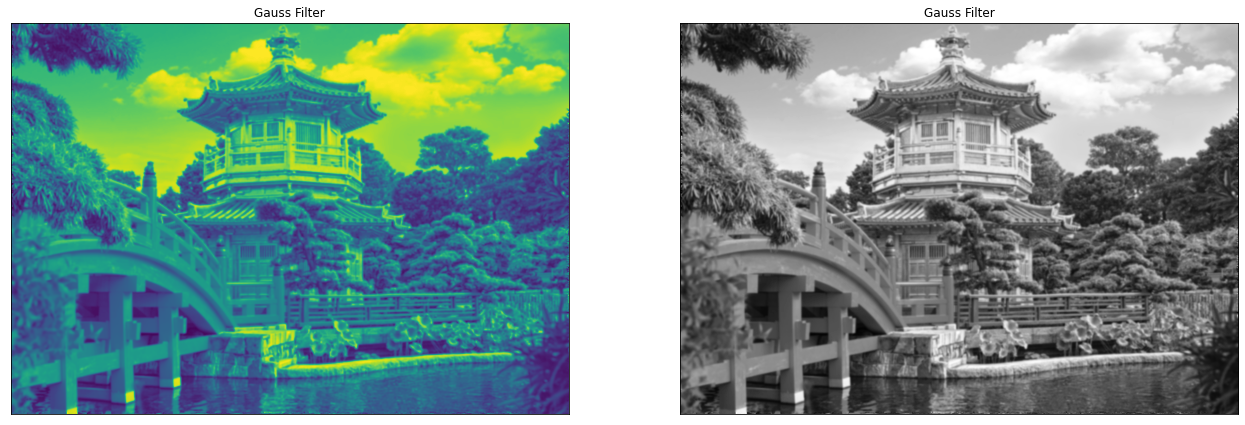

In [0]:
plt.figure(figsize=(22,12))
plt.subplot(121)
plt.imshow(img)
plt.title("Gauss Filter")
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(img, cmap='gray')
plt.title("Gauss Filter")
plt.xticks([])
plt.yticks([])
plt.show()

In [0]:
def generage_octave(im):
  octave = [im]
  k = 2 ** (1 / s)
  kernel = gaussian_filter(k * sigma)
  for i in range(s + 2):
    next_img = convolve(octave[-1], kernel)
    octave.append(next_img)
  return octave

In [0]:
def generage_gaussian_pyramid():
  pyramid = []
  im = img.copy()
  for i in range(num_octave):
    octave = generage_octave(im)
    pyramid.append(octave)
    im = octave[-3][::2, ::2]
  return pyramid


In [0]:
gaussian_pyramid = generage_gaussian_pyramid()

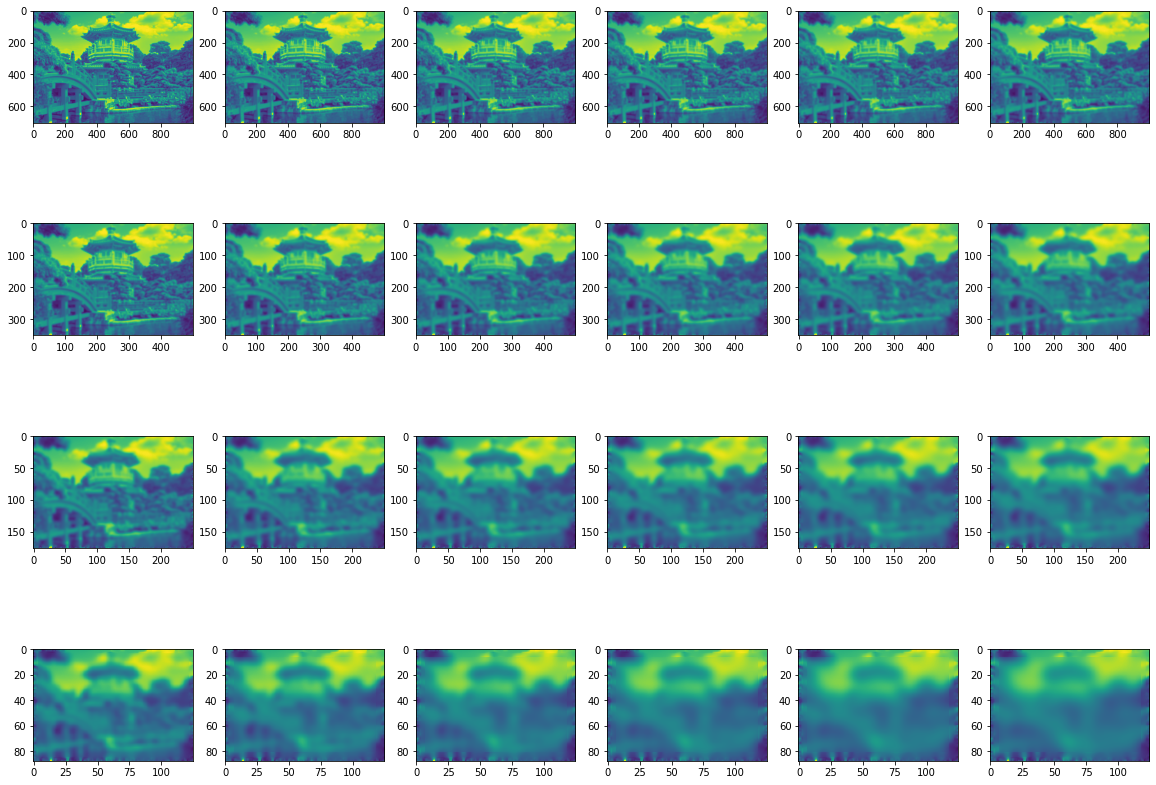

In [0]:
r = len(gaussian_pyramid)
c = len(gaussian_pyramid[0])
f, axarr = plt.subplots(r, c)
f.set_figwidth(20)
f.set_figheight(15)
for i in range(r):
  for j in range(c):
    axarr[i,j].imshow(gaussian_pyramid[i][j])


In [0]:
def generage_DOG_octave(gaussian_octave):
  DOG_octave = []
  for i in range(1, len(gaussian_octave)):
    DOG_octave.append(gaussian_octave[i] - gaussian_octave[i - 1])
    
  return DOG_octave#np.concatenate([octave[:,:,np.newaxis] for octave in DOG_octave], axis=2)


In [0]:
def generage_DOG_pyramid():
  DOG_pyramid = []
  for gaussian_octave in gaussian_pyramid:
    DOG_pyramid.append(generage_DOG_octave(gaussian_octave=gaussian_octave))
  return DOG_pyramid

In [0]:
DOG_pyramid = generage_DOG_pyramid()

4 5


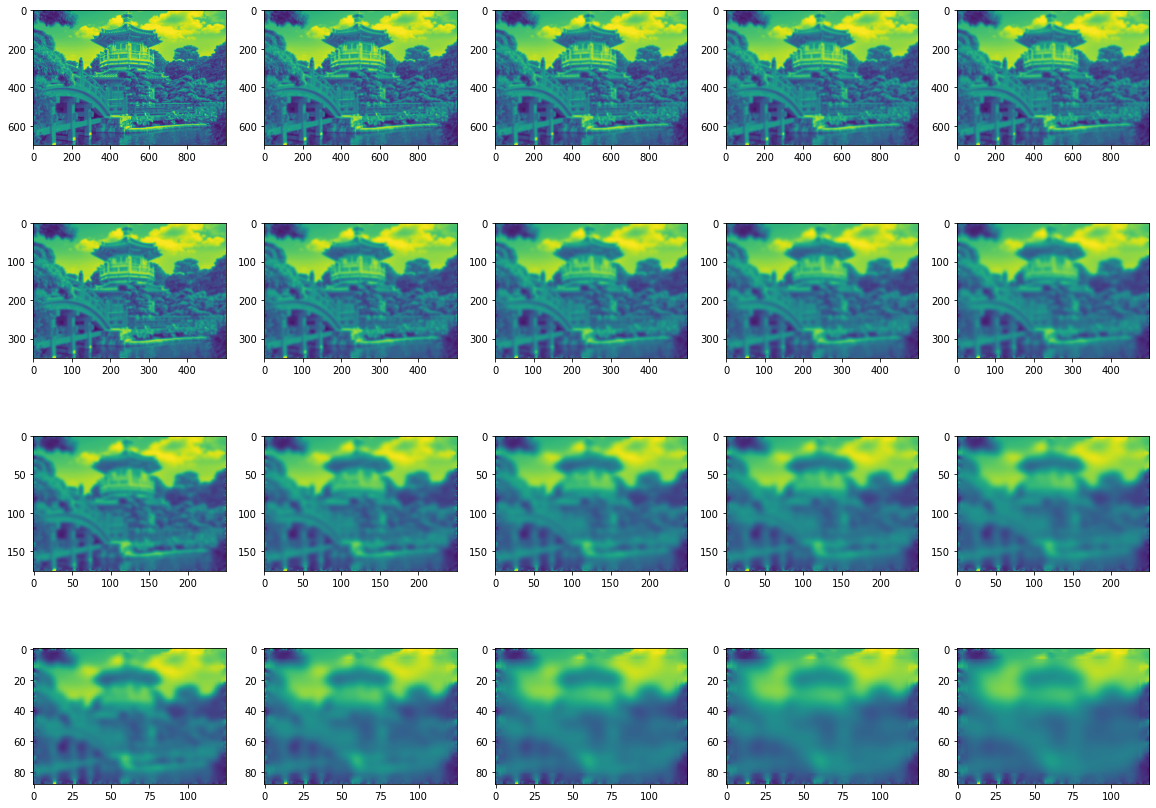

In [0]:
r = len(DOG_pyramid)
c = len(DOG_pyramid[0])
# print(r, c)
f, axarr = plt.subplots(r, c)
f.set_figwidth(20)
f.set_figheight(15)
for i in range(r):
  for j in range(c):
    axarr[i,j].imshow(gaussian_pyramid[i][j])

In [0]:
def get_candidate_keypoints(D, w=16):
	candidates = []

	''' Start '''
	# These 2 lines aren't specified in the paper but it makes it so the extrema
	# are found within the entire octave. They are always found in the first or
	# last layer so I probably have something wrong with my DoG pyramid construction.
	D[:,:,0] = 0
	D[:,:,-1] = 0
	''' End '''
	
	# have to start at w//2 so that when getting the local w x w descriptor, we don't fall off
	for i in range(w//2+1, D.shape[0]-w//2-1):
		for j in range(w//2+1, D.shape[1]-w//2-1):
			for k in range(1, D.shape[2]-1): 
				patch = D[i-1:i+2, j-1:j+2, k-1:k+2]
				if np.argmax(patch) == 13 or np.argmin(patch) == 13:
					candidates.append([i, j, k])

	return candidates

In [0]:
def localize_keypoint(D, x, y, s):
	dx = (D[y,x+1,s]-D[y,x-1,s])/2.
	dy = (D[y+1,x,s]-D[y-1,x,s])/2.
	ds = (D[y,x,s+1]-D[y,x,s-1])/2.

	dxx = D[y,x+1,s]-2*D[y,x,s]+D[y,x-1,s]
	dxy = ((D[y+1,x+1,s]-D[y+1,x-1,s]) - (D[y-1,x+1,s]-D[y-1,x-1,s]))/4.
	dxs = ((D[y,x+1,s+1]-D[y,x-1,s+1]) - (D[y,x+1,s-1]-D[y,x-1,s-1]))/4.
	dyy = D[y+1,x,s]-2*D[y,x,s]+D[y-1,x,s]
	dys = ((D[y+1,x,s+1]-D[y-1,x,s+1]) - (D[y+1,x,s-1]-D[y-1,x,s-1]))/4.
	dss = D[y,x,s+1]-2*D[y,x,s]+D[y,x,s-1]

	J = np.array([dx, dy, ds])
	HD = np.array([
		[dxx, dxy, dxs],
		[dxy, dyy, dys],
		[dxs, dys, dss]])
	
	offset = -LA.inv(HD).dot(J)	# I know you're supposed to do something when an offset dimension is >0.5 but I couldn't get anything to work.
	return offset, J, HD[:2,:2], x, y, s


In [0]:
def find_keypoints_for_DoG_octave(DOG_octave):
	candidates = get_candidate_keypoints(D, w)
	#print('%d candidate keypoints found' % len(candidates))

	keypoints = []

	for i, cand in enumerate(candidates):
		y, x, s = cand[0], cand[1], cand[2]
		offset, J, H, x, y, s = localize_keypoint(D, x, y, s)

		contrast = D[y,x,s] + .5*J.dot(offset)
		if abs(contrast) < t_c: continue

		w, v = LA.eig(H)
		r = w[1]/w[0]
		R = (r+1)**2 / r
		if R > R_th: continue

		kp = np.array([x, y, s]) + offset
		if kp[1] >= D.shape[0] or kp[0] >= D.shape[1]: continue # throw out boundary points because I don't want to deal with them

		keypoints.append(kp)

	#print('%d keypoints found' % len(keypoints))
	return np.array(keypoints)

In [0]:
def get_keypoints():
    keypoints = []

    for DOG_octave in DOG_pyramid:
        keypoints.append(find_keypoints_for_DoG_octave(DOG_octave))

    return kps

In [0]:
keypoints_pyramid = get_keypoints()